In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import soundfile
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import build
from dct import isdct, sdct
from models import *
from train import generate

In [2]:
class DaNet(pl.LightningModule):
    def __init__(self, model_loader, noise=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = eval(model_loader)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, aux = batch
        x += torch.randn_like(x) * self.noise
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [3]:
model = DaNet.load_from_checkpoint('Data/epoch=105-step=1060.ckpt')

In [4]:
x = torch.randn((1, 256, 10))
y = model(x)[0]
print(y.shape)
print(y.std(dim=1))

torch.Size([256, 10])
tensor([1.0699, 1.3640, 1.3034, 1.2912, 1.1173, 1.3384, 0.8899, 1.0092, 1.3199,
        1.2456, 1.1033, 1.6544, 1.6900, 2.1115, 1.9073, 1.9519, 2.1093, 2.5034,
        2.6420, 2.5193, 2.6258, 2.6832, 2.9438, 2.6654, 2.8504, 2.7420, 2.7978,
        2.8323, 2.5864, 2.4572, 2.3574, 2.5100, 2.2045, 2.1082, 1.9399, 1.8897,
        1.6671, 1.5503, 1.4295, 1.2702, 1.1367, 1.1202, 0.9743, 0.9385, 0.9284,
        1.0203, 1.0380, 1.1262, 1.0525, 1.1170, 1.1005, 1.1826, 1.1134, 1.2961,
        1.1668, 1.2767, 1.2679, 1.4260, 1.3689, 1.5254, 1.5025, 1.3950, 1.4787,
        1.4766, 1.5480, 1.5902, 1.5837, 1.5010, 1.5436, 1.5501, 1.4608, 1.5382,
        1.5670, 1.5272, 1.4940, 1.4653, 1.4245, 1.3757, 1.4761, 1.3018, 1.2994,
        1.2420, 1.2779, 1.1697, 1.2301, 1.1877, 1.0757, 1.1518, 1.0629, 1.2471,
        1.1286, 1.1098, 1.1424, 1.0889, 0.9773, 0.9687, 1.0691, 1.0700, 1.1911,
        1.2361, 1.1640, 1.0652, 1.1661, 1.2455, 1.1892, 1.1151, 1.1641, 1.1857,
        1.1699, 1.

In [17]:
x = generate(model, 1000, start=t[:, :500], show_progress=True)

100%|██████████| 1000/1000 [00:15<00:00, 65.37it/s]


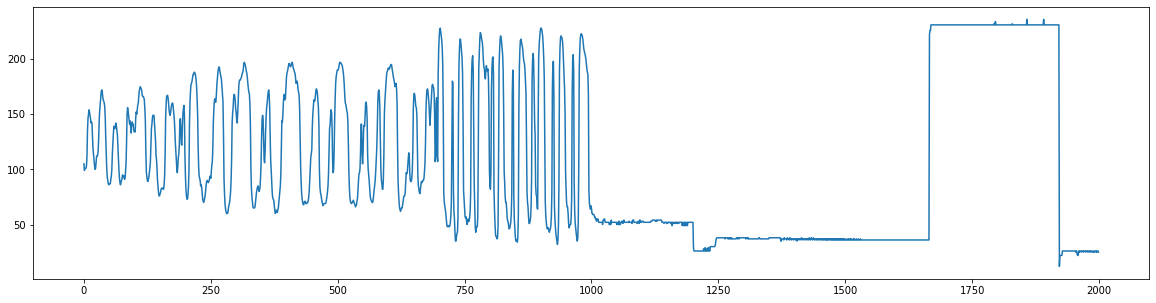

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(x[:, :].argmax(dim=0))
plt.show()

In [12]:
import build
loader = build.dataloader(data='dataset_v6', part=0.1, batch_size=10, shuffle=True)
t, _ = next(iter(loader))
t = t[0][:, :1000]
t.shape

torch.Size([256, 1000])

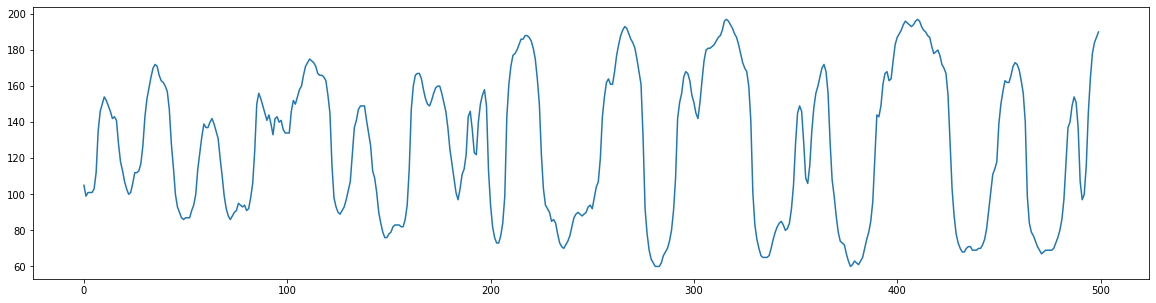

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(t[:, :500].argmax(dim=0))
plt.show()

tensor(190) 5.130897521972656 0.03649109601974487 -6.518133640289307 5.529400825500488
tensor(185) 5.529400825500488 0.054356902837753296 tensor(3.1848e-07) tensor(0.0544) tensor(1.)


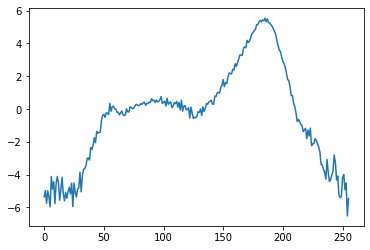

###
tensor(190) 59.02226257324219 0.19691208004951477 -73.8475112915039 60.040428161621094
tensor(193) 60.040428161621094 0.5450747609138489 tensor(0.) tensor(0.5451) tensor(1.)


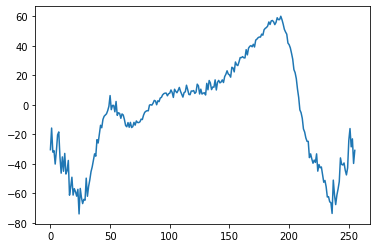

###
tensor(192) 61.94002914428711 0.035672955214977264 -77.05021667480469 64.8992691040039
tensor(193) 64.8992691040039 0.6878926157951355 tensor(0.) tensor(0.6879) tensor(1.)


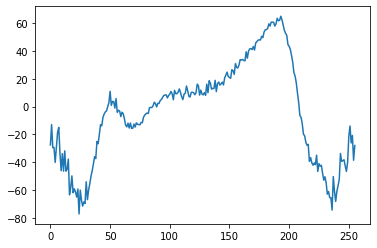

###
tensor(195) 47.646522521972656 0.00024329115694854409 -68.81062316894531 55.23883819580078
tensor(190) 55.23883819580078 0.48242202401161194 tensor(0.) tensor(0.4824) tensor(1.0000)


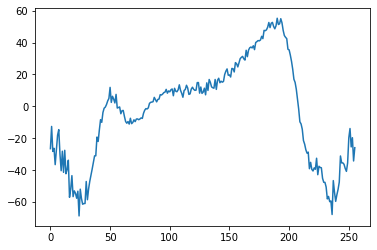

###
tensor(197) 15.876917839050293 3.696783824125305e-05 -39.47645568847656 25.745750427246094
tensor(190) 25.745750427246094 0.7141732573509216 tensor(3.3741e-29) tensor(0.7142) tensor(1.0000)


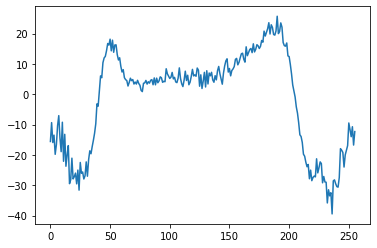

###
tensor(197) 0.29418742656707764 2.215052312848787e-14 -35.152774810791016 31.311717987060547
tensor(54) 31.311717987060547 0.6548265814781189 tensor(8.9323e-30) tensor(0.6548) tensor(1.)


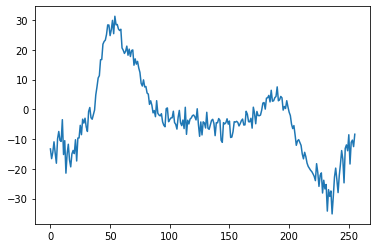

###
tensor(196) -1.081836462020874 4.170916016672842e-15 -44.7540283203125 31.290546417236328
tensor(65) 31.290546417236328 0.4779459536075592 tensor(4.5044e-34) tensor(0.4779) tensor(1.0000)


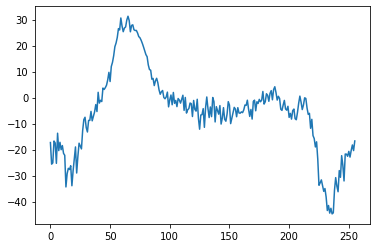

###
tensor(196) 2.5753142833709717 2.5593685157310198e-12 -40.14898681640625 29.233287811279297
tensor(65) 29.233287811279297 0.9672616124153137 tensor(7.1319e-31) tensor(0.9673) tensor(1.0000)


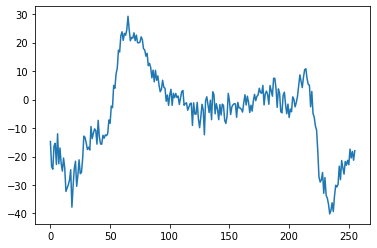

###
tensor(195) 1.0640376806259155 2.5799482550326047e-09 -28.57085418701172 20.402633666992188
tensor(65) 20.402633666992188 0.64603590965271 tensor(3.4781e-22) tensor(0.6460) tensor(1.0000)


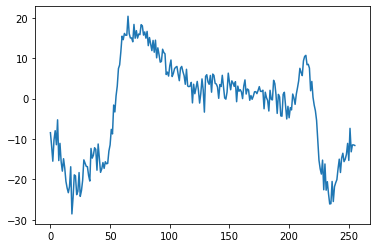

###
tensor(194) -8.842516899108887 3.2246323666829113e-12 -15.184685707092285 15.532939910888672
tensor(70) 15.532939910888672 0.12433889508247375 tensor(5.6769e-15) tensor(0.1243) tensor(1.)


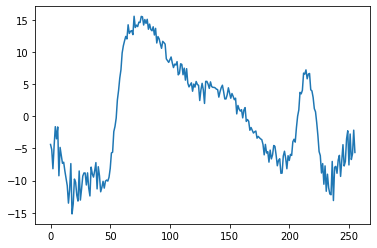

###


In [16]:
buffer = t[:, :500]
for i in range(10):
    buffer = torch.cat((buffer, torch.zeros((256, 1))), dim=1)
    predict = model(buffer.unsqueeze(0))[0, :, -1]
    prob = F.softmax(predict, dim=0).detach()
    nxt = t[:, 500 + i].argmax()
    idx = predict.argmax()
    print(nxt, predict[nxt].item(), prob[nxt].item(), predict.min().item(), predict.max().item())
    print(idx, predict[idx].item(), prob[idx].item(), prob.min(), prob.max(), prob.sum())
    plt.plot(predict.detach().numpy())
    plt.show()
    print('###')
    buffer[:, -1] = predict